In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contourpy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from _FigureJiazeHelper import *
from _DetectabilityWithMeta import *
from _CommunityDetect import *
from EXPERIMENT import get_range_delta, read_exp
from scipy.optimize import linear_sum_assignment

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=10)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 10  # 'large'
plt.rcParams['lines.markersize'] = 12
plt.rcParams['axes.linewidth'] = 0.5

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [3]:
def get_confusionmatrix(truePartition, cdPartition, trueNumgroup, cdNumgroup):
    confusionMatrix = np.zeros((trueNumgroup, cdNumgroup))
    for iTrue in range(trueNumgroup):
        trueIndex = np.where(truePartition==iTrue)
        for iCD in range(cdNumgroup):
            confusionMatrix[iTrue, iCD] = np.size(np.where(cdPartition[trueIndex]==iCD))
#     print(confusionMatrix)
    true_ind, CD_ind = linear_sum_assignment(confusionMatrix, maximize=True)
    print(f'True index is {true_ind}, Community detected index is {CD_ind}')
    confusionMatrix[:, np.sort(CD_ind)] = confusionMatrix[:, CD_ind]
    return confusionMatrix, CD_ind

# Confusion Matrix Of Subgraph For n=12000, X=2, Z=3, d=50, delta=0.01. Different rho

rhos=[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
 deltas=[-0.005  -0.0045 -0.004  -0.0035 -0.003  -0.0025 -0.002  -0.0015 -0.001
 -0.0005  0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035  0.004
  0.0045  0.005   0.0055  0.006   0.0065  0.007   0.0075  0.008   0.0085
  0.009   0.0095  0.01    0.0105  0.011   0.0115  0.012   0.0125  0.013
  0.0135  0.014   0.0145  0.015   0.0155  0.016   0.0165  0.017   0.0175
  0.018   0.0185  0.019   0.0195  0.02    0.0205  0.021   0.0215  0.022
  0.0225  0.023   0.0235  0.024   0.0245  0.025 ]
Metadata generation done!
number of groups = 3
True Sub Group Number is 6
BH Sub Group Number is 3
True index is [3 4 5], Community detected index is [0 2 1]
rho is 0.1, AMI is 0.7771456134740387, Confusion Matrix is
 [[  92.   79.   45.]
 [  

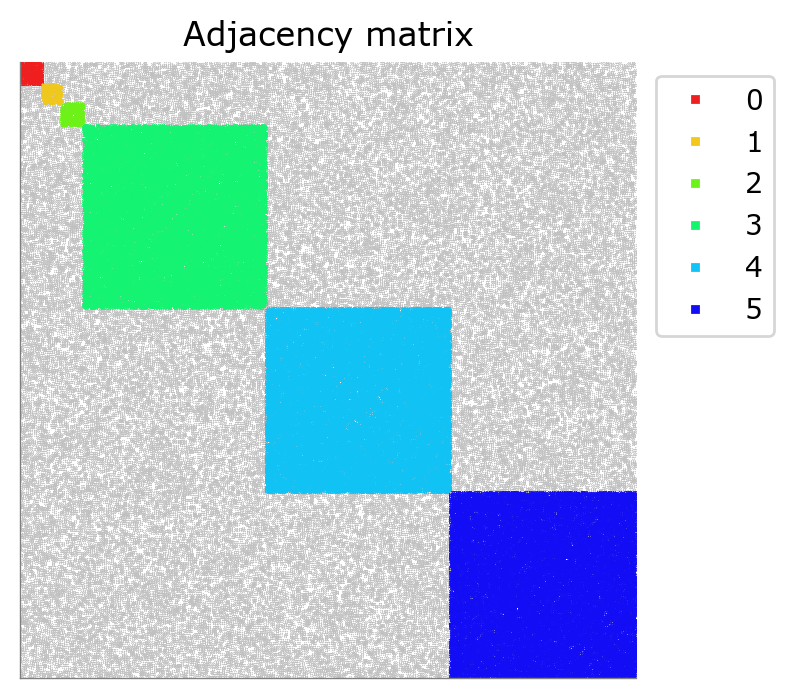

In [9]:
X = 2
Z = 3
n = X*Z*2000
d = 50
min_delta, max_delta = get_range_delta(d, n, X, Z)
rhos = np.setdiff1d(np.around(np.linspace(0, 1, 51), 2), np.array([]))
deltas = np.setdiff1d(np.around(np.linspace(min_delta, max_delta, int((max_delta-min_delta)/0.0005)+1), 5), np.array([0]))
print(f'rhos={rhos}\n deltas={deltas}')
rho = 0.1
delta = 0.01
pin = d / n + delta * (1 - 1 / (X * Z))
pout = d / n - delta / (X * Z)
pin = 0 if pin < 1e-10 else pin
pout = 0 if pout < 1e-10 else pout
msbm = SymMetaSBM(n, X, Z, rho, pin, pout)
A = msbm.sample()
subA, subGroupId = msbm.filter(A, metaId=0)
subTrueNumgroup = np.size(np.unique(subGroupId))
subBHpartition, subBHNumgroup = CommunityDetect(subA).BetheHessian()
print(f'True Sub Group Number is {subTrueNumgroup}')
print(f'BH Sub Group Number is {subBHNumgroup}')
confusionMatrix, _ = get_confusionmatrix(subGroupId, subBHpartition, subTrueNumgroup, subBHNumgroup)
np.set_printoptions(suppress = True)
print(f'rho is {rho}, AMI is {adjusted_mutual_info_score(subGroupId, subBHpartition)}, Confusion Matrix is\n {confusionMatrix}')
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=6)
_, indexes, counts = np.unique(subGroupId, return_index=True, return_counts=True)
counts = counts[np.argsort(indexes)]
plot_block_matrix(subA.toarray(), partition_names=list(range(6)), partition_counts=counts, colors=c, ms=0.01)

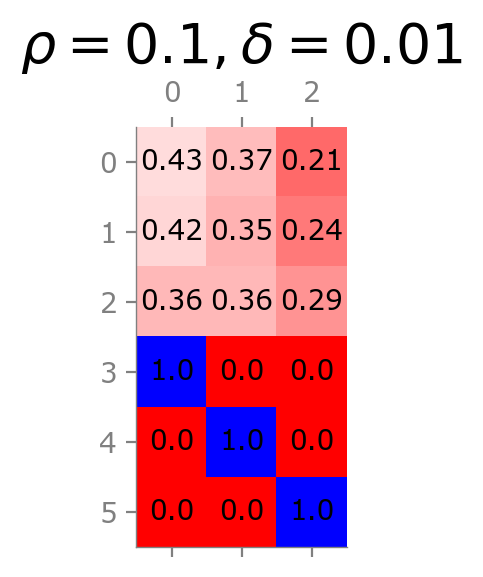

In [11]:
rowsum = np.sum(confusionMatrix, axis=1)
rowsum = rowsum.reshape(-1, 1)
rowsum = np.repeat(rowsum, subBHNumgroup, axis=1)
normConfusionMatrix = np.round(confusionMatrix / rowsum, 2)
fig = plt.figure(figsize=(3, 3))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])

cmap = mpl.colormaps["bwr_r"]
ax.matshow(normConfusionMatrix, cmap=cmap)
for i in range(subTrueNumgroup):
    for j in range(subBHNumgroup):
        c = normConfusionMatrix[i,j]
        ax.text(j, i, str(c), va='center', ha='center')
ax.set_title(rf"$\rho={rho}, \delta={delta}$", fontsize=20)
# ax.set_ylabel("True Community", rotation='horizontal', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
save_path = "./_Figure/Minority/" + f"FigureMinorityConfuMatrix_q{X*Z}_rho{rho}_delta{delta}" + ".pdf"
plt.tight_layout()
plt.savefig(save_path, dpi=600)

Metadata generation done!
number of groups = 4
True Sub Group Number is 6
BH Sub Group Number is 4
True index is [1 3 4 5], Community detected index is [3 1 0 2]
rho is 0.24, AMI is 0.76141049039421, Confusion Matrix is
 [[ 419.   12.   17.   13.]
 [ 465.    4.    8.    7.]
 [ 443.    8.    7.    8.]
 [  80. 1447.    0.    0.]
 [ 104.    0. 1435.    0.]
 [  75.    0.    0. 1464.]]


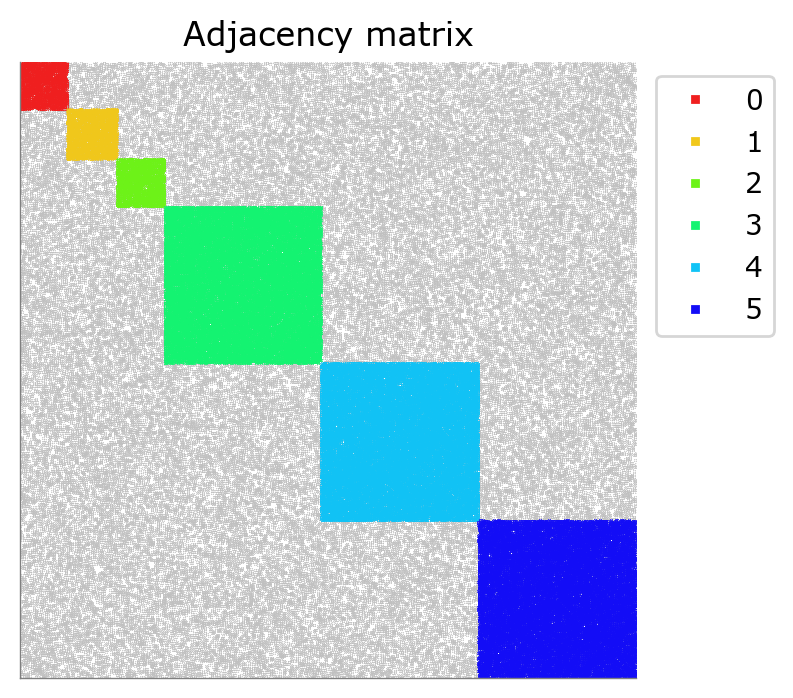

In [12]:
rho = 0.24
msbm = SymMetaSBM(n, X, Z, rho, pin, pout)
A = msbm.sample()
subA, subGroupId = msbm.filter(A, metaId=0)
subTrueNumgroup = np.size(np.unique(subGroupId))
subBHpartition, subBHNumgroup = CommunityDetect(subA).BetheHessian()
print(f'True Sub Group Number is {subTrueNumgroup}')
print(f'BH Sub Group Number is {subBHNumgroup}')
confusionMatrix, _ = get_confusionmatrix(subGroupId, subBHpartition, subTrueNumgroup, subBHNumgroup)
np.set_printoptions(suppress = True)
print(f'rho is {rho}, AMI is {adjusted_mutual_info_score(subGroupId, subBHpartition)}, Confusion Matrix is\n {confusionMatrix}')
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=6)
_, indexes, counts = np.unique(subGroupId, return_index=True, return_counts=True)
counts = counts[np.argsort(indexes)]
plot_block_matrix(subA.toarray(), partition_names=list(range(6)), partition_counts=counts, colors=c, ms=0.01)

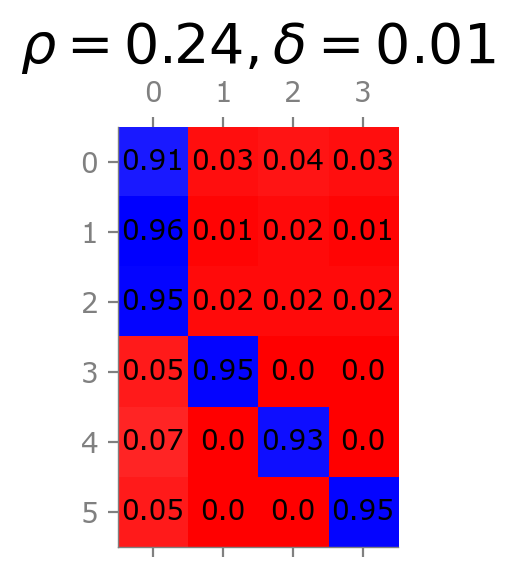

In [13]:
rowsum = np.sum(confusionMatrix, axis=1)
rowsum = rowsum.reshape(-1, 1)
rowsum = np.repeat(rowsum, subBHNumgroup, axis=1)
normConfusionMatrix = np.round(confusionMatrix / rowsum, 2)
fig = plt.figure(figsize=(4, 3))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])

cmap = mpl.colormaps["bwr_r"]
ax.matshow(normConfusionMatrix, cmap=cmap)
for i in range(subTrueNumgroup):
    for j in range(subBHNumgroup):
        c = normConfusionMatrix[i,j]
        ax.text(j, i, str(c), va='center', ha='center')
ax.set_title(rf"$\rho={rho}, \delta={delta}$", fontsize=20)
# ax.set_ylabel("True Community", rotation='horizontal', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
save_path = "./_Figure/Minority/" + f"FigureMinorityConfuMatrix_q{X*Z}_rho{rho}_delta{delta}" + ".pdf"
plt.tight_layout()
plt.savefig(save_path, dpi=600)

Metadata generation done!
number of groups = 6
True Sub Group Number is 6
BH Sub Group Number is 6
True index is [0 1 2 3 4 5], Community detected index is [3 0 1 4 2 5]
rho is 0.3, AMI is 0.8334130288989995, Confusion Matrix is
 [[ 536.   19.   25.   13.   11.    7.]
 [  20.  523.   35.    5.   10.    8.]
 [  12.   20.  543.    3.    5.    5.]
 [   5.   15.   19. 1347.    2.    2.]
 [  10.   21.   27.    2. 1330.    1.]
 [   9.   12.   21.    1.    2. 1323.]]


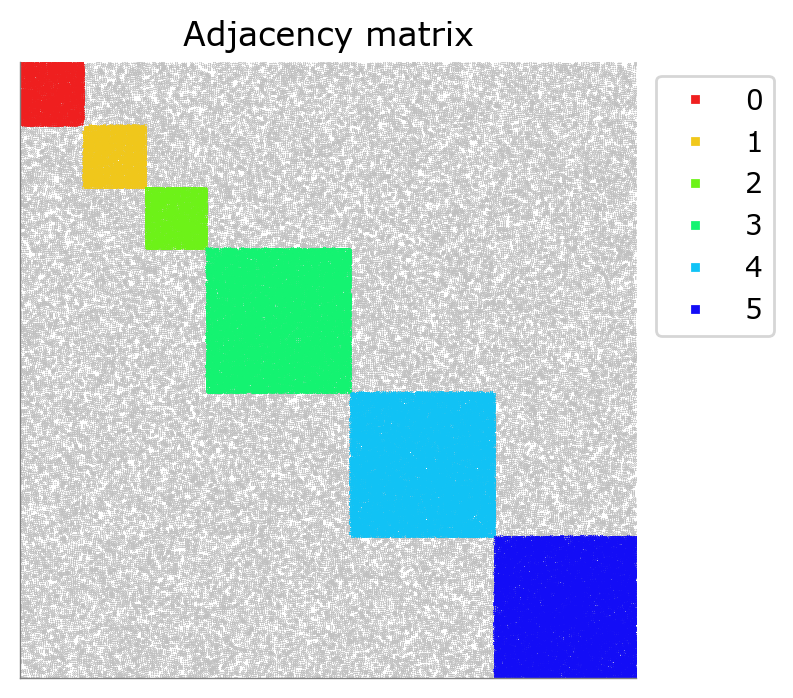

In [52]:
rho = 0.3
msbm = SymMetaSBM(n, X, Z, rho, pin, pout)
A = msbm.sample()
subA, subGroupId = msbm.filter(A, metaId=0)
subTrueNumgroup = np.size(np.unique(subGroupId))
subBHpartition, subBHNumgroup = CommunityDetect(subA).BetheHessian()
print(f'True Sub Group Number is {subTrueNumgroup}')
print(f'BH Sub Group Number is {subBHNumgroup}')
confusionMatrix, _ = get_confusionmatrix(subGroupId, subBHpartition, subTrueNumgroup, subBHNumgroup)
np.set_printoptions(suppress = True)
print(f'rho is {rho}, AMI is {adjusted_mutual_info_score(subGroupId, subBHpartition)}, Confusion Matrix is\n {confusionMatrix}')
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=6)
_, indexes, counts = np.unique(subGroupId, return_index=True, return_counts=True)
counts = counts[np.argsort(indexes)]
plot_block_matrix(subA.toarray(), partition_names=list(range(6)), partition_counts=counts, colors=c, ms=0.01)

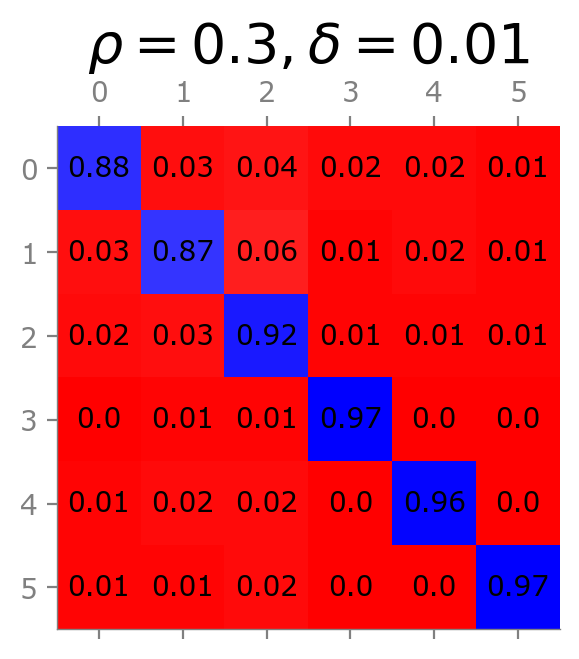

In [55]:
rowsum = np.sum(confusionMatrix, axis=1)
rowsum = rowsum.reshape(-1, 1)
rowsum = np.repeat(rowsum, subBHNumgroup, axis=1)
normConfusionMatrix = np.round(confusionMatrix / rowsum, 2)
fig = plt.figure(figsize=(3, 6))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])

cmap = mpl.colormaps["bwr_r"]
ax.matshow(normConfusionMatrix, cmap=cmap)
for i in range(subTrueNumgroup):
    for j in range(subBHNumgroup):
        c = normConfusionMatrix[i,j]
        ax.text(j, i, str(c), va='center', ha='center')
ax.set_title(rf"$\rho={rho}, \delta={delta}$", fontsize=20)
# ax.set_ylabel("True Community", rotation='horizontal', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
save_path = "./_Figure/Minority/" + f"FigureMinorityConfuMatrix_q{X*Z}_rho{rho}_delta{delta}" + ".pdf"
plt.tight_layout()
plt.savefig(save_path, dpi=600)

# AMISNR imshow

In [6]:
# For big n
X = 2
Z = 3
n = X*Z*2000
d = 50
Withsnr = True
givenNumGroup = False
DC = False
HelpWithFull = False
LabelPropagate = False
fileId = 'amiExp5.17' + f'_n={n}_X={X}_Z={Z}_d={round(d)}_{"snr" if Withsnr else ""}'
load_path = "./result/detectabilityWithMeta/" + fileId + ".txt"
addfileId = 'amiExp8.8' + f'_n={n}_X={X}_Z={Z}_d={round(d)}_{"snr" if Withsnr else ""}_' + \
                 f'{"givenNumGroup" if givenNumGroup else ""}_' + \
                 f'{"DC" if DC else ""}_{"HelpWithFull" if HelpWithFull else ""}_' + \
                 f'{"LabelPropagate" if LabelPropagate else ""}' + '_add'
addload_path = "./result/detectabilityWithMeta/" + addfileId + ".txt"
plot_rhos, plot_zs, full_ami, sub_ami, snr_nm, snr_m, full_num_group, sub_num_group = read_exp(load_path=load_path, Withsnr=Withsnr, givenNumGroup=givenNumGroup, old=False, add_path=addload_path)

In [8]:
rho = np.setdiff1d(np.around(np.linspace(0, 1, 51), 2), np.array([]))
min_delta, max_delta = get_range_delta(d, n, X, Z)
delta = np.setdiff1d(np.around(np.linspace(min_delta, max_delta, int((max_delta-min_delta)/0.0005)+1), 5), np.array([0]))
CH_m_exact = np.zeros(np.size(delta)*np.size(rho))
Lambda4 = np.zeros(np.size(delta)*np.size(rho))
Lambda3 = np.zeros(np.size(delta)*np.size(rho))
Lambda2 = np.zeros(np.size(delta)*np.size(rho))
Lambda1 = np.zeros(np.size(delta)*np.size(rho))
i = 0
for _rho in rho:
    for _delta in delta:
        pin = d/n+_delta-_delta/(2*Z)
        pout = d/n-_delta/(2*Z)
        pin = 0 if pin < 1e-10 else pin
        pout = 0 if pout < 1e-10 else pout
        lambda2_ = (2*Z*d+n*_delta+np.sqrt((2*Z*d-n*_delta)**2+(8*n*Z*d*_delta)*((1-2*_rho)**2))) / (4 * n)
        lambda3_ = (2*Z*d+n*_delta-np.sqrt((2*Z*d-n*_delta)**2+(8*n*Z*d*_delta)*((1-2*_rho)**2))) / (4 * n)
        Lambda1[i] = n / (2 * Z) * lambda2_
        if _rho < 1/2:
            CH_m_exact[i] = _rho * ((np.sqrt(pin)-np.sqrt(pout))**2) * (n / (2*Z*np.log(n/2)))
            Lambda2[i] = n / (2 * Z) * (1-_rho) * _delta
            if _delta > 0:
                Lambda3[i] = n / (2 * Z) * lambda3_
                Lambda4[i] = n / (2 * Z) * (_rho) * _delta
            else:
                Lambda3[i] = n / (2 * Z) * (_rho) * _delta
                Lambda4[i] = n / (2 * Z) * lambda3_
        else:
            CH_m_exact[i] = (1-_rho) * ((np.sqrt(pin)-np.sqrt(pout))**2) * (n / (2*Z*np.log(n/2)))
            Lambda2[i] = n / (2 * Z) * (_rho) * _delta
            if _delta > 0:
                Lambda3[i] = n / (2 * Z) * lambda3_
                Lambda4[i] = n / (2 * Z) * (1-_rho) * _delta
            else:
                Lambda3[i] = n / (2 * Z) * (1-_rho) * _delta
                Lambda4[i] = n / (2 * Z) * lambda3_
        i+=1

6


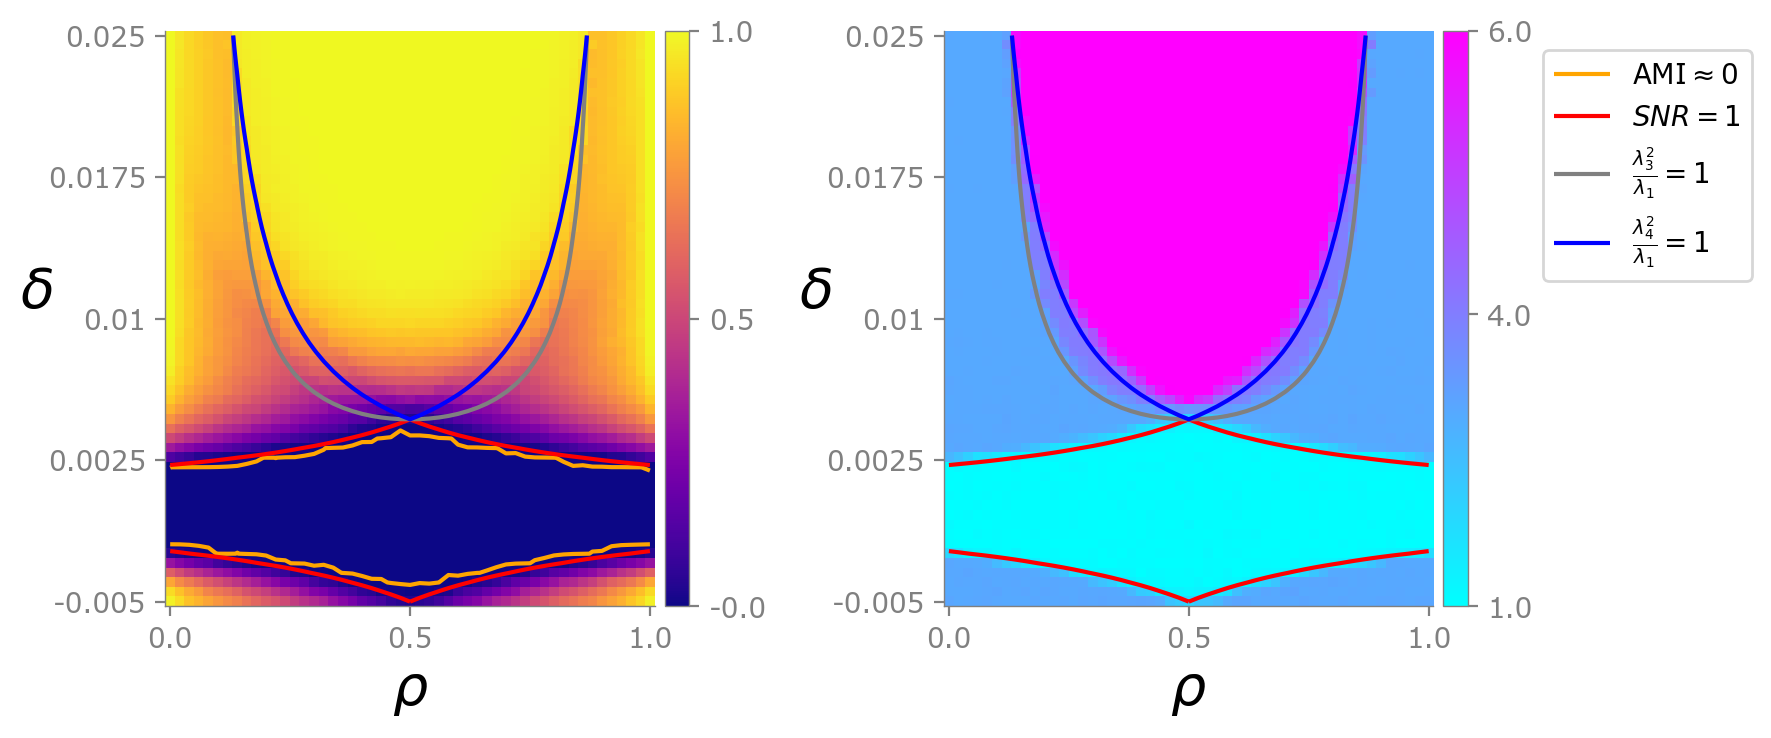

In [25]:
fig = plt.figure(figsize=(9, 6))
widths = [4, 4]
heights = [6]
spec5 = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["plasma"]
zcenter = 0.5
plot_subami = color_imshow_2d(plot_rhos, plot_zs, sub_ami, z_center=zcenter, title="", xlabel=r'$\rho$', ylabel=r'$\delta$', cmap=cmap, ax=ax, fig=fig)
# remove two side contour
# plot_subami[20:, 45:]=0.5
# plot_subami[20:, :5]=0.5
# plot_subami[:2, 45:]=0.5
# plot_subami[:2, :5]=0.5
# amiupper = 0.999
# contour_data(plot_subami, ax, levels=[amiupper], fmt={amiupper: rf'AMI$\simeq$1'}, color='blue')
handels = []
handels += contour_data(plot_subami, ax, levels=[1e-3], fmt={1e-3: r'AMI$\approx$0'}, color='orange', inline=False)
plot_snrm = color_imshow_2d(plot_rhos, plot_zs, snr_m, z_center=1, return_gridz=True)
handels += contour_data(plot_snrm, ax, levels=[1], fmt={1: r'$SNR=1$'}, color='red', inline=False)
# plot_ch_exact = color_imshow_2d(plot_rhos, plot_zs, CH_m_exact, z_center=1, return_gridz=True)
# contour_data(plot_ch_exact, ax, levels=[1], fmt={1: r'$CH=1$'}, color='red')
plot_l3overl1 = color_imshow_2d(plot_rhos, plot_zs, Lambda3**2/Lambda1, z_center=1, return_gridz=True)
handels += contour_data(plot_l3overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_3^2}{\lambda_1}=1$'}, color='gray', inline=False)
plot_l4overl1 = color_imshow_2d(plot_rhos, plot_zs, Lambda4**2/Lambda1, z_center=1, return_gridz=True)
handels += contour_data(plot_l4overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_4^2}{\lambda_1}=1$'}, color='blue', inline=False)


row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["cool"]
plot_subnumgroup = color_imshow_2d(plot_rhos, plot_zs, sub_num_group, z_center=4, title="", xlabel=r'$\rho$', ylabel=r'$\delta$', cmap=cmap, ax=ax, fig=fig, vmax=6)
nummid = 5
# contour_data(plot_subnumgroup, ax, levels=[nummid], fmt={nummid: rf'# of communities={nummid}'}, color='blue')
contour_data(plot_snrm, ax, levels=[1], fmt={1: r'$SNR=1$'}, color='red', inline=False)
contour_data(plot_l3overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_3^2}{\lambda_1}=1$'}, color='gray', inline=False)
contour_data(plot_l4overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_4^2}{\lambda_1}=1$'}, color='blue', inline=False)
plt.legend(handels, [r'AMI$\approx$0', r'$SNR=1$', r'$\frac{\lambda_3^2}{\lambda_1}=1$', r'$\frac{\lambda_4^2}{\lambda_1}=1$'], 
           loc=2, bbox_to_anchor=(3.5, 0.99), fontsize=10, markerscale=2)
plt.subplots_adjust(wspace=0.5)
save_path = "./_Figure/Minority/" + "FigureMinorityAMISNR_q6" + ".pdf"
plt.tight_layout()
plt.savefig(save_path, dpi=600)